<a href="https://colab.research.google.com/github/naseemdabiran/CIS_9660/blob/main/Brain%20Tumor%20Detection%20in%20MRI%20Scan%20-%20Clustering%20K-Means%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project 2: Brain Tumors Detection Using Supervised and Unsupervised Machine Learning Algorithms - Clustering**

Naseem Dabiran 

In [ ]:
# Installing pyclustering

!pip install pyclustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing the required libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from numpy import mean
from numpy import std
import seaborn as sns

from google.colab import drive
from os import listdir
from os.path import isfile, join

from skimage.feature import local_binary_pattern
from skimage.io import imread, imshow
from skimage.transform import  resize
from skimage.color import rgb2gray
from skimage.filters import prewitt_h,prewitt_v

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster.encoder import cluster_encoder

In [ ]:
# Connect notebook to google drive
drive.mount('/content/drive')  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#viewing all of the files within the folder
!ls '/content/drive/MyDrive/cis 9660 project 2/brain_mri'

'gg (100).jpg'	'gg (636).jpg'	'm2 (138).jpg'	 no177.jpg	'p (306).jpg'
 gg100.jpg	'gg (637).jpg'	'm2 (139).jpg'	 no178.jpg	'p (307).jpg'
'gg (101).jpg'	'gg (638).jpg'	'm2 (13).jpg'	 no179.jpg	'p (308).jpg'
'gg (102).jpg'	'gg (639).jpg'	'm2 (140).jpg'	'no 17.jpg'	'p (309).jpg'
'gg (103).jpg'	'gg (63).jpg'	'm2 (141).jpg'	 no17.jpg	'p (30).jpg'
'gg (104).jpg'	 gg63.jpg	'm2 (142).jpg'	 no180.jpg	 p30.jpg
'gg (105).jpg'	'gg (640).jpg'	'm2 (143).jpg'	 no181.jpg	'p (310).jpg'
'gg (106).jpg'	'gg (641).jpg'	'm2 (144).jpg'	 no182.jpg	'p (311).jpg'
'gg (107).jpg'	'gg (642).jpg'	'm2 (145).jpg'	 no183.jpg	'p (312).jpg'
'gg (108).jpg'	'gg (643).jpg'	'm2 (146).jpg'	 no184.jpg	'p (313).jpg'
'gg (109).jpg'	'gg (644).jpg'	'm2 (147).jpg'	 no185.jpg	'p (314).jpg'
'gg (10).jpg'	'gg (645).jpg'	'm2 (148).jpg'	 no186.jpg	'p (315).jpg'
 gg10.jpg	'gg (646).jpg'	'm2 (149).jpg'	 no187.jpg	'p (316).jpg'
'gg (110).jpg'	'gg (647).jpg'	'm2 (14).jpg'	 no188.jpg	'p (317).jpg'
'gg (111).jpg'	'gg (648).jpg'	'm2 (150).jpg'

In [ ]:
# Location where images are stored
mypath = '/content/drive/MyDrive/cis 9660 project 2/brain_mri'

# Make a folder for all images 
# Source: https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
image_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [ ]:
# Create and fill image dictionary 

image_categories_dict = {'Category':[],
                         'Image_Name':[]
                         }

for image in image_files:
  if 'no' in image:
    image_categories_dict['Category'].append('no tumor')
    image_categories_dict['Image_Name'].append(image)

  elif 'm' in image:
    image_categories_dict['Category'].append('meningioma')
    image_categories_dict['Image_Name'].append(image)
    
  elif 'gg' in image:
    image_categories_dict['Category'].append('glioma')
    image_categories_dict['Image_Name'].append(image)

  elif 'p' in image :
    image_categories_dict['Category'].append('pituitary tumor')
    image_categories_dict['Image_Name'].append(image)

In [ ]:
# Create a dataframe from image dictionary
brain_mri_df = pd.DataFrame(image_categories_dict)
brain_mri_df

,Category,Image_Name
0,pituitary tumor,p (698).jpg
1,pituitary tumor,p (810).jpg
2,pituitary tumor,p (701).jpg
3,pituitary tumor,p (703).jpg
4,pituitary tumor,p (735).jpg
...,...,...
3259,glioma,gg (416).jpg
3260,glioma,gg (118).jpg
3261,glioma,gg (434).jpg
3262,glioma,gg (276).jpg


In [ ]:
brain_mri_df['Category'].value_counts()

meningioma         937
glioma             926
pituitary tumor    901
no tumor           500
Name: Category, dtype: int64

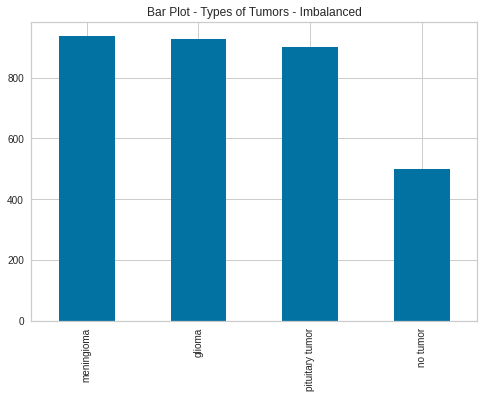

In [ ]:
brain_mri_df['Category'].value_counts().plot(kind='bar')
plt.title('Bar Plot - Types of Tumors - Imbalanced')
plt.show()

In [ ]:
# Balance dataframe

sample_size = 500

#source: https://stackoverflow.com/questions/41858827/selecting-n-elements-of-each-class
brain_mri_df = brain_mri_df.groupby('Category', as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, sample_size, False),:])

In [ ]:
brain_mri_df['Category'].value_counts()

glioma             500
meningioma         500
no tumor           500
pituitary tumor    500
Name: Category, dtype: int64

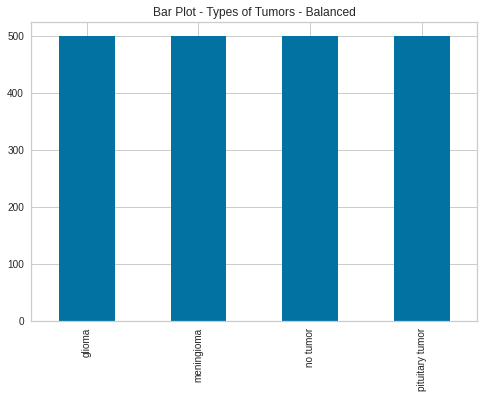

In [ ]:
brain_mri_df['Category'].value_counts().plot(kind='bar')
plt.title('Bar Plot - Types of Tumors - Balanced')
plt.show()

In [ ]:
# Feature Extraction Function 

def feature_extraction(i): 

  # Path of image
  image_path = mypath + '/' + i
 
  # Reading the image and resizing 
  image = imread(image_path)
  image = resize(image, (100,100))

  # RGB feature extraction
  rgb_feature_matrix = image[:,:,0] + image[:,:,1] + image[:,:,2] #finding the sum of the RGB values for all 3 RGB bands for each pixel
  rgb_feature_matrix = rgb_feature_matrix / 3 #finding the average RGB value for each pixel by dividing by 3
  rgb_features = np.reshape(rgb_feature_matrix, (100*100)) #flattening the features array into a single 1D vector

  # LBP feature extraction
  METHOD = 'uniform'  # at most two circular 0-1 or 1-0 transitions
  radius = 1  # distance between central pixels and comparison pixels
  n_points = 8 * radius  # define number of comparison pixels
  gray_image = rgb2gray(image) 
  lbp_image = local_binary_pattern(gray_image, n_points, radius, METHOD)
  lbp_features = np.reshape(lbp_image, (100*100))

  # Horizontal Edges
  horizontal_edges = prewitt_h(gray_image)
  horizontal_edges = np.reshape(horizontal_edges, (100*100)) 

  # Vertical Edges 
  vertical_edges = prewitt_v(gray_image)
  vertical_edges = np.reshape(vertical_edges, (100*100)) 

  # Concatenating all features 
  features = (np.concatenate((rgb_features, lbp_features, horizontal_edges, vertical_edges)))
  return features

In [ ]:
# Add Feature Extraction to DataFrame
image_list = brain_mri_df['Image_Name'].tolist()

#Initialize list
features_list = []

for image in image_list:
  features_list.append(feature_extraction(image))

# Add to dataframe
brain_mri_df['Features'] = features_list

In [ ]:
brain_mri_df.head()

Category    Image_Name  \
0 2285   glioma  gg (366).jpg   
  1042   glioma  gg (777).jpg   
  3117   glioma  gg (573).jpg   
  2272   glioma  gg (541).jpg   
  3076   glioma  gg (610).jpg   

                                                 Features  
0 2285  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
  1042  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
  3117  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
  2272  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
  3076  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [ ]:
# Unsupervised Learning - Comparision of all tumor types
# K-means

image_list = brain_mri_df['Image_Name'].tolist()  
features_list = brain_mri_df['Features'].tolist()

# Convert feature extraction to np array
all_features = np.array(features_list)
  
# Splitting dataset into features and targets 
X = all_features
y = brain_mri_df['Category'].values

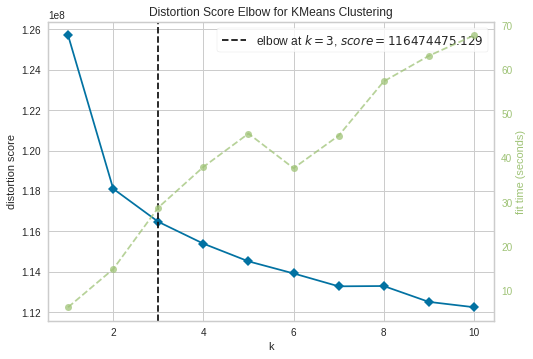

In [ ]:
# Determine optimal number of clusters

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 11))

visualizer.fit(X) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

In [ ]:
# Perform K-Means Clustering 

# instatiate KMeans class and set the number of clusters
km_model = KMeans(n_clusters=4, random_state=10)

# call fit method with data 
km = km_model.fit_predict(X)

# coordinates of cluster center
centroids = km_model.cluster_centers_ 

# cluster label for each data point
labels = km_model.labels_ 

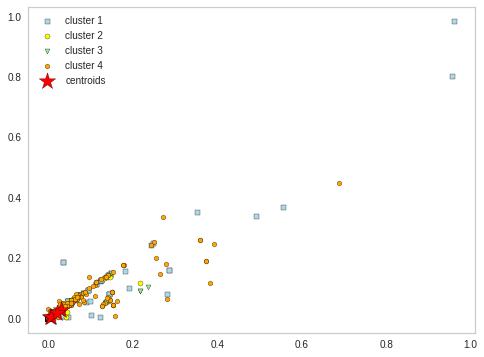

In [ ]:
# Visualize Clusters

plt.figure(figsize=(8,6))
plt.scatter(
    X[km == 0, 0], X[km == 0, 1],
    s=25, c='lightblue',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[km == 1, 0], X[km == 1, 1],
    s=25, c='yellow',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X[km == 2, 0], X[km == 2, 1],
    s=25, c='lightgreen',
    marker='v', edgecolor='black',
    label='cluster 3'
)
plt.scatter(
    X[km == 3, 0], X[km == 3, 1],
    s=25, c='orange',
    marker='h', edgecolor='black',
    label='cluster 4'
)

# visualise centroids
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    s=300, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [ ]:
# Purity Score function
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    confusion_matrix = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix)

# Report Purity Score
purity = purity_score(y, labels)
print(f"The purity score is {round(purity*100, 2)}%")

The purity score is 43.4%


In [ ]:
# define dictionary for distance measures
distance_measures = {'euclidean': 0, 'squared euclidean': 1, 'manhattan': 2, 'chebyshev': 3, 
                    'canberra': 5, 'chi-square': 6}

# function defined to compute purity score using pyclustering for various distance measures
def pyPurity(dist_measure):
    initial_centers = random_center_initializer(X, 3, random_state=5).initialize()
    # instance created for respective distance metric
    instanceKm = kmeans(X, initial_centers=initial_centers, metric=distance_metric(dist_measure))
    # perform cluster analysis
    instanceKm.process()
    # cluster analysis results - clusters and centers
    pyClusters = instanceKm.get_clusters()
    pyCenters = instanceKm.get_centers()
    # enumerate encoding type to index labeling to get labels
    pyEncoding = instanceKm.get_cluster_encoding()
    pyEncoder = cluster_encoder(pyEncoding, pyClusters, X)
    pyLabels = pyEncoder.set_encoding(0).get_clusters()
    # function purity score is defined in previous section
    return purity_score(y, pyLabels)

# print results
for measure, value in distance_measures.items():
    print(f"The purity score for {measure} distance is {round(pyPurity(value)*100, 2)}%")

The purity score for euclidean distance is 38.55%
The purity score for squared euclidean distance is 38.55%
The purity score for manhattan distance is 43.65%
The purity score for chebyshev distance is 25.1%
The purity score for canberra distance is 45.7%
The purity score for chi-square distance is 39.85%


In [ ]:
# Binary Classifications:

# Glioma vs No Tumor
# Menigioma vs No Tumor
# Pituitary Tumor No Tumor
# Glioma vs Menigioma 
# Glioma vs Pituitary Tumor
# Menigioma vs Pituitary Tumor

# Create smaller dataframes for each binary classification
df1 = brain_mri_df.loc[(brain_mri_df['Category'] == 'glioma' ) | (brain_mri_df['Category'] == 'no tumor' )]
df2 = brain_mri_df.loc[(brain_mri_df['Category'] == 'meningioma' ) | (brain_mri_df['Category'] == 'no tumor' )]
df3 = brain_mri_df.loc[(brain_mri_df['Category'] == 'pituitary tumor' ) | (brain_mri_df['Category'] == 'no tumor' )]
df4 = brain_mri_df.loc[(brain_mri_df['Category'] == 'glioma' ) | (brain_mri_df['Category'] == 'meningioma' )]
df5 = brain_mri_df.loc[(brain_mri_df['Category'] == 'glioma' ) | (brain_mri_df['Category'] == 'pituitary tumor' )]
df6 = brain_mri_df.loc[(brain_mri_df['Category'] == 'meningioma' ) | (brain_mri_df['Category'] == 'pituitary tumor' )]

categories= {'Glioma vs No Tumor': df1,
             'Meningioma vs No Tumor': df2, 
             'Pituitary Tumor vs No Tumor': df3,
             'Glioma vs Meningioma': df4,
             'Glioma vs Pituitary Tumor': df5,
             'Meningioma vs Pituitary Tumor': df6,
            }

In [ ]:
# Double check counts in one dataframe
df1['Category'].value_counts()

glioma      500
no tumor    500
Name: Category, dtype: int64

Glioma vs No Tumor


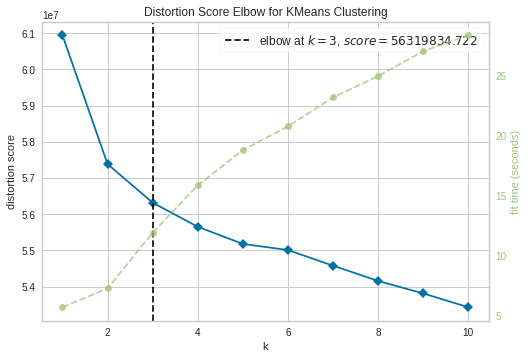

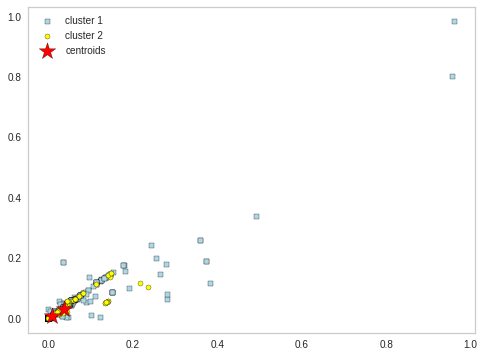

The purity score is 63.0%
Meningioma vs No Tumor


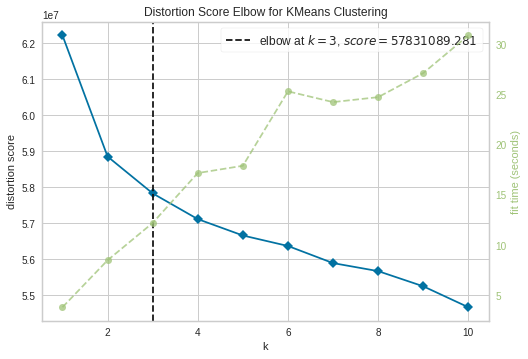

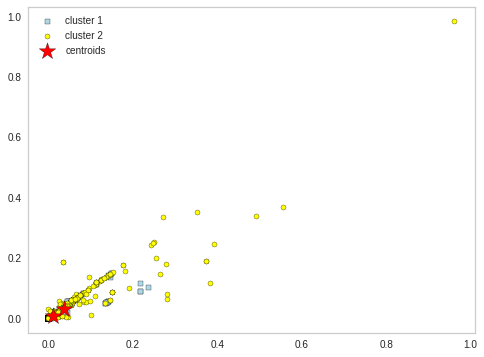

The purity score is 53.8%
Pituitary Tumor vs No Tumor


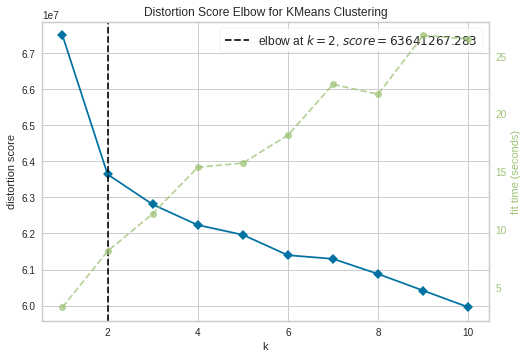

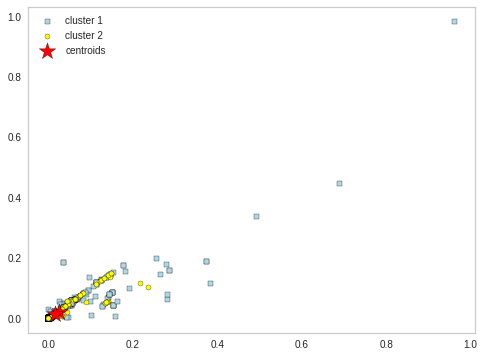

The purity score is 69.0%
Glioma vs Meningioma


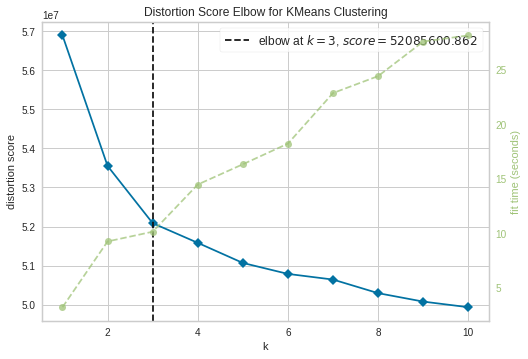

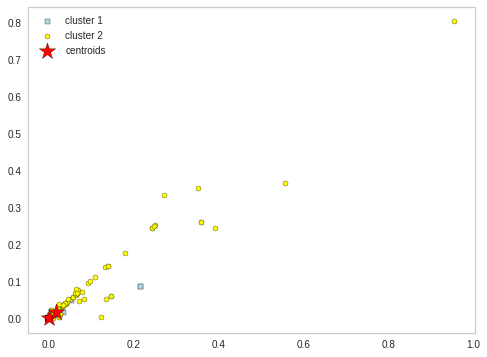

The purity score is 57.8%
Glioma vs Pituitary Tumor


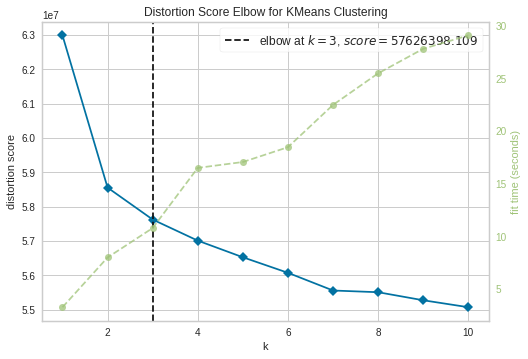

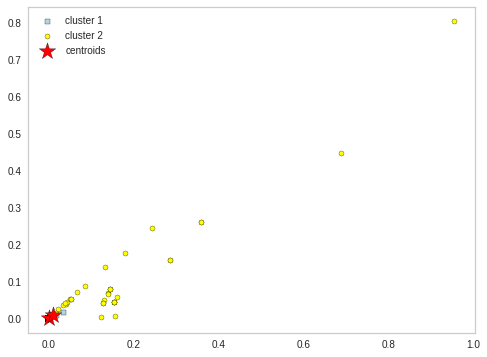

The purity score is 75.4%
Meningioma vs Pituitary Tumor


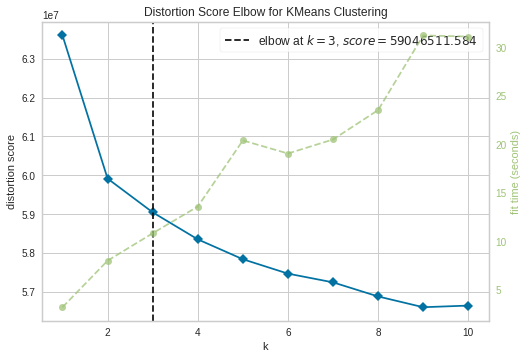

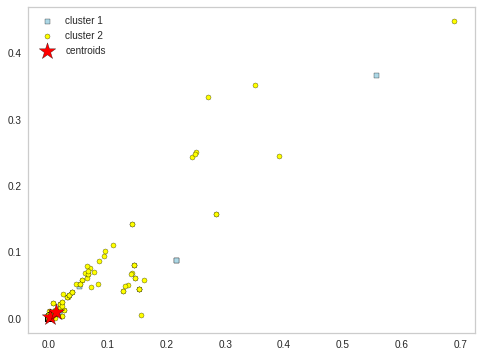

The purity score is 68.5%


In [ ]:
# Additional Code 
# Binary Clustering

for comparison in categories:
  print(comparison, end = '\n')
  
  df = categories[comparison]
  image_list = df['Image_Name'].tolist()  
  features_list = df['Features'].tolist()

  # Convert feature extraction to np array
  all_features = np.array(features_list)
    
  # Splitting dataset into features and targets 
  X = all_features
  y = df['Category'].values

  # Instantiate the clustering model and visualizer
  model = KMeans()
  visualizer = KElbowVisualizer(model, k=(1, 11))

  visualizer.fit(X) # Fit the data to the visualizer
  visualizer.show() # Finalize and render the figure
  plt.show()

  # instatiate KMeans class and set the number of clusters
  km_model = KMeans(n_clusters=2, random_state=10)

  # call fit method with data 
  km = km_model.fit_predict(X)

  # coordinates of cluster center
  centroids = km_model.cluster_centers_ 

  # cluster label for each data point
  labels = km_model.labels_ 
  
  # Visualize Clusters

  plt.figure(figsize=(8,6))
  plt.scatter(
      X[km == 0, 0], X[km == 0, 1],
      s=25, c='lightblue',
      marker='s', edgecolor='black',
      label='cluster 1'
  )

  plt.scatter(
      X[km == 1, 0], X[km == 1, 1],
      s=25, c='yellow',
      marker='o', edgecolor='black',
      label='cluster 2'
  )

  # visualise centroids
  plt.scatter(
      centroids[:, 0], centroids[:, 1],
      s=300, marker='*',
      c='red', edgecolor='black',
      label='centroids'
  )
  plt.legend(scatterpoints=1)
  plt.grid()
  plt.show()

  purity = purity_score(y, labels)
  print(f"The purity score is {round(purity*100, 2)}%")